In [1]:
!pip install adversarial-robustness-toolbox git+https://github.com/pesser/pytorch_diffusion.git -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.0 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 98.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 107.8 MB/s eta 0:00:0000:01


Using device: cuda


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.015686275..1.0156863].


Adversarial accuracy (no defense): 21.88%
Accuracy after UNet purification: 40.62%


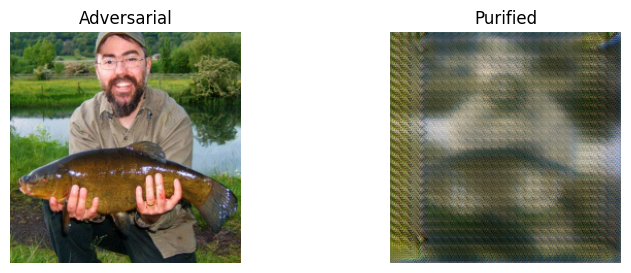

In [4]:
# ============================================================
# ImageNet UNet Purification Evaluation Pipeline (Single Script)
# ============================================================

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import random

from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier

# -----------------------
# Config
# -----------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
N_ADV_SAMPLES = 64
IMG_SIZE = 224

print("Using device:", DEVICE)

# -----------------------
# ImageNet normalization
# -----------------------
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(DEVICE)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(DEVICE)

def normalize_imagenet(x):
    return (x - IMAGENET_MEAN) / IMAGENET_STD

# -----------------------
# Dataset (ImageFolder – NO devkit)
# -----------------------
# 🔴 CHANGE THIS PATH to the dataset you attached in Kaggle
DATASET_ROOT = "/kaggle/input/imagenet100"

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor()
])

test_dataset = torchvision.datasets.ImageFolder(
    root=DATASET_ROOT,
    transform=transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# -----------------------
# Pretrained ImageNet classifier
# -----------------------
classifier = torchvision.models.resnet18(weights="IMAGENET1K_V1")
classifier = classifier.to(DEVICE)
classifier.eval()

# -----------------------
# ART wrapper + PGD
# -----------------------
criterion = nn.CrossEntropyLoss()

art_classifier = PyTorchClassifier(
    model=classifier,
    loss=criterion,
    optimizer=None,
    input_shape=(3, IMG_SIZE, IMG_SIZE),
    nb_classes=1000,
    device_type=DEVICE.type
)

pgd_attack = ProjectedGradientDescent(
    estimator=art_classifier,
    eps=4/255,
    eps_step=1/255,
    max_iter=5,
    batch_size=BATCH_SIZE
)

# -----------------------
# UNet Purifier (MUST match training architecture)
# -----------------------
class PurifierUNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU()
        )

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU()
        )

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU()
        )

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 3, 3, padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        b  = self.bottleneck(self.pool3(e3))

        d3 = self.dec3(torch.cat([self.up3(b), e3], 1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], 1))
        return self.dec1(torch.cat([self.up1(d2), e1], 1))

purifier = PurifierUNet().to(DEVICE)
purifier.load_state_dict(
    torch.load(
        "/kaggle/input/unet-purifier-model/pytorch/default/1/purifier_unet_imagenet.pth",
        map_location=DEVICE
    )
)
purifier.eval()

# -----------------------
# Generate adversarial samples
# -----------------------
x_clean, y = next(iter(test_loader))
x_clean = x_clean[:N_ADV_SAMPLES].to(DEVICE)
y = y[:N_ADV_SAMPLES].to(DEVICE)

x_adv = pgd_attack.generate(x_clean.cpu().numpy())
x_adv = torch.tensor(x_adv).to(DEVICE)

# -----------------------
# Evaluation
# -----------------------
with torch.no_grad():
    logits_adv = classifier(normalize_imagenet(x_adv))
    acc_adv = (logits_adv.argmax(1) == y).float().mean().item() * 100

    x_pur = purifier(x_adv)
    logits_pur = classifier(normalize_imagenet(x_pur))
    acc_pur = (logits_pur.argmax(1) == y).float().mean().item() * 100

print(f"Adversarial accuracy (no defense): {acc_adv:.2f}%")
print(f"Accuracy after UNet purification: {acc_pur:.2f}%")

# -----------------------
# Visualization
# -----------------------
idx = random.randint(0, logits_adv.size(0) - 1)

plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.imshow(x_adv[idx].permute(1,2,0).cpu())
plt.title("Adversarial")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(x_pur[idx].permute(1,2,0).cpu())
plt.title("Purified")
plt.axis("off")

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.015686275..1.0156863].


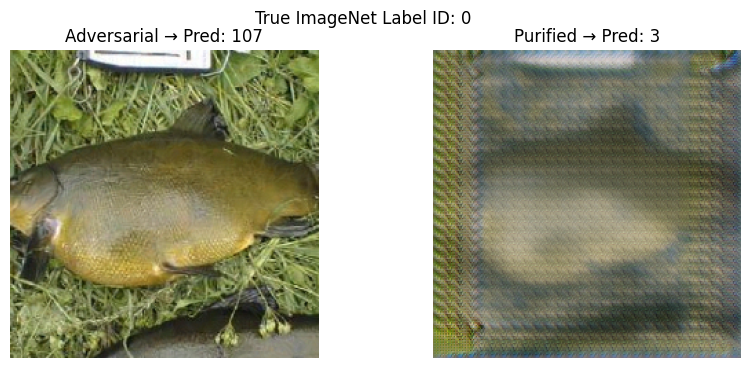

In [13]:
# %%
import matplotlib.pyplot as plt
import random

# Pick a random adversarial sample from the current batch
idx = random.randint(0, x_adv.size(0) - 1)

adv_img = x_adv[idx:idx+1]
true_label = y[idx].item()

classifier.eval()
purifier.eval()

with torch.no_grad():
    pred_adv = classifier(normalize_imagenet(adv_img)).argmax(1).item()
    purified_img = purifier(adv_img)
    pred_pur = classifier(normalize_imagenet(purified_img)).argmax(1).item()

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(adv_img.squeeze().permute(1, 2, 0).cpu().numpy())
plt.title(f"Adversarial → Pred: {pred_adv}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(purified_img.squeeze().permute(1, 2, 0).cpu().numpy())
plt.title(f"Purified → Pred: {pred_pur}")
plt.axis('off')

plt.suptitle(f"True ImageNet Label ID: {true_label}")
plt.show()
